# 1D Wave Equation with Dirichlet boundary conditions

### From the wave example in NeuralPDE

Let's solve this 1-dimensional wave or advection equation: with initial conditions $u(x,0) = x(1-x)$

```math
\begin{align*}
∂_t u(x, t) = c ∂_x u(x, t) \quad & \textsf{for all } 0 < x < 1 \text{ and } t > 0 \, , \\
u(x, 0) = x (1-x)     \quad & \textsf{for all } 0 < x < 1 \, , \\
\end{align*}
```
We try some boundary conditions to see whether ir works ok, and what one gets with wrong boundary values.
with grid discretization `dx = 0.1` and physics-informed neural networks.
With boundary conditions in both sides
(a problem ill posed)
```math
u(0, t) = u(1, t) = 0 \quad  \textsf{for all } t > 0 \, ,
```
It converges to something it is not a solution.

With 
```math
u(0, t) = 0 \quad  \textsf{for all } t > 0 \, ,
```
we get the correct solution.

With 
```math
u(1, t) = 0 \quad  \textsf{for all } t > 0 \, ,
```

Also converges to something that is not a solution. So one should be worried that in complex situations one does not get into something which is not a solution and nevertheless the lost function is very small. 

With this example we look at several things:

1. Convergence vs. loss function 
2. Convergence vs. different sampling strategies. 
3. long time Convergence
4. efect of wrong boundary conditions.
5. smoothness? 


In [17]:
using NeuralPDE, Lux, Optimization, OptimizationOptimJL
using ModelingToolkit, IntervalSets 
using IntervalSets
using Plots, Printf

@parameters t, x
@variables u(..)
Dx = Differential(x)
Dt = Differential(t)


Differential(t)

In [18]:

#2D PDE
C = 1
eq = Dt(u(t, x)) ~ C * Dx(u(t, x))



Differential(t)(u(t, x)) ~ Differential(x)(u(t, x))

In [19]:
tf = 2.0
# Space and time domains
@show domains = [t ∈ Interval(0.0, tf),
    x ∈ Interval(0.0, 1.0)]
# Discretization
dx = 0.005


domains = [t ∈ Interval(0.0, tf), x ∈ Interval(0.0, 1.0)] = Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0.0 .. 2.0), Symbolics.VarDomainPairing(x, 0.0 .. 1.0)]


0.005

In [20]:


# Initial and boundary conditions

boundary_conditions = true
correct_bc = true
incorrect_bc_1 = false
incorrect_bc_2 = false

if incorrect_bc_1
    bcs = [u(t, 0) ~ 0.0,# for all t > 0
    u(t, 1) ~ 0.0,# for all t > 0
    u(0, x) ~ x * (1.0 - x)] #for all 0 < x < 1
elseif incorrect_bc_2
    bcs = [u(t, 0) ~ 0.0,# for all t > 0
    u(0, x) ~ x * (1.0 - x)] #for all 0 < x < 1
elseif correct_bc
bcs = [u(t, 1) ~ 0.0,# for all t > 0
    #u(0, x) ~ x * (1.0 - x)] #for all 0 < x < 1
    u(0, x) ~ sin(16*π*x)]
end

2-element Vector{Equation}:
 u(t, 1) ~ 0.0
 u(0, x) ~ sin(50.26548245743669x)

In [21]:

# Neural network
N_input = 2
N_neurons = 16
N_output = 1
N_layers = 1

chain = Chain(Dense(N_input, N_neurons, σ), Dense(N_neurons, N_neurons, σ), Dense(N_neurons, N_output))

@show (N_input * N_neurons + N_layers * N_neurons^2  + N_neurons * N_output    
                        + (1+N_layers) * N_neurons + N_output)

# Discretization
different_samplings = true


points = 30_000
bcs_points = 5_00


#strategy = GridTraining(dx)
#strategy = NeuralPDE.StochasticTraining(points, bcs_points = bcs_points)
# #=
strategy = NeuralPDE.QuasiRandomTraining(points, bcs_points = points,
                            sampling_alg = NeuralPDE.LatinHypercubeSample(), resampling = true,
                            minibatch = 300)
# =#
discretization = PhysicsInformedNN(chain, strategy)

NonAdaptiveLoss(; pde_loss_weights = 1.0,
                  bc_loss_weights = 100.0,
                  additional_loss_weights = 1.0)
                  
@named pde_system = PDESystem(eq, bcs, domains, [t, x], [u(t, x)])
prob = discretize(pde_system, discretization)

loss = []
callback = function (p, l)
    println("Current loss is: $l")
    push!(loss, l)
    return false
end

N_input * N_neurons + N_layers * N_neurons ^ 2 + N_neurons * N_output + (1 + N_layers) * N_neurons + N_output = 337


#25 (generic function with 1 method)

In [22]:

# optimizer
#opt = OptimizationOptimJL.BFGS()
opt = OptimizationOptimJL.SSBroyden()
res = Optimization.solve(prob, opt; callback, maxiters = 2000)
phi = discretization.phi




Current loss is: 0.5114855584738608
Current loss is: 0.5011944821911426
Current loss is: 0.49962245224743745
Current loss is: 0.4995808257180682
Current loss is: 0.49943991890670314
Current loss is: 0.4994168179488599
Current loss is: 0.4989281944431896
Current loss is: 0.4987700855589895
Current loss is: 0.49876250984990866
Current loss is: 0.4987026922164638
Current loss is: 0.4984263289652816
Current loss is: 0.4981313860772289
Current loss is: 0.4979345693458838
Current loss is: 0.4976039584527165
Current loss is: 0.49755404035430245
Current loss is: 0.4975003103986986
Current loss is: 0.49729117635828185
Current loss is: 0.4972362359195086
Current loss is: 0.4970119328585064
Current loss is: 0.49697504403789017
Current loss is: 0.4968082856365488
Current loss is: 0.49659563545954366
Current loss is: 0.49651950149452684
Current loss is: 0.4964275783732519
Current loss is: 0.49623913681523535
Current loss is: 0.49614590691684796
Current loss is: 0.4960301573818717
Current loss is: 0

NeuralPDE.Phi{StatefulLuxLayer{Val{true}, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}}(StatefulLuxLayer{Val{true}, Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}(Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.Tru

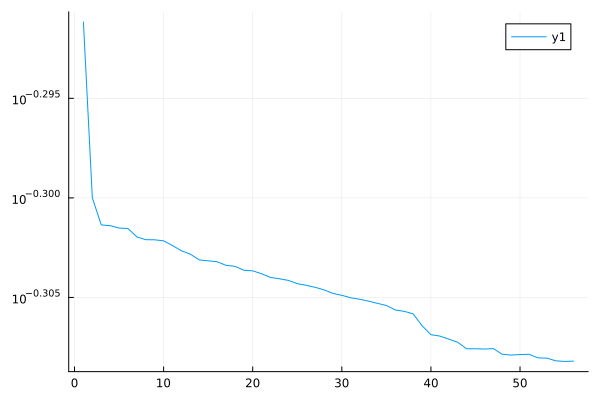

In [23]:
plot(loss, yscale=:log10)

In [8]:
if boundary_conditions 
    if correct_bc
        loss_correct = copy(loss)
    elseif incorrect_bc_1
        loss_incorrect_1 = copy(loss)
    elseif incorrect_bc_2
        loss_incorrect_2 = copy(loss)
    end
end

if different_samplings
    if strategy isa NeuralPDE.QuasiRandomTraining
        if batch == 50
            loss_QR50 = copy(loss)
        elseif batch == 100
            loss_QR100 = copy(loss)
        end
    elseif strategy isa NeuralPDE.GridTraining
        loss_GT = []
    end
end 






UndefVarError: UndefVarError: `batch` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing Polyester in the current active module Main

In [9]:
#=
plot(log10.(loss_QR50),label="QuasiRandom, 20000, 300, MB=50", title="Different sampling methods")
plot!(log10.(loss_QR100),label="QuasiRandom, 20000, 300, MB=100")
plot!(log10.(loss_GT),label="Grid, dx=0.1")
#savefig("advection_loss_strategies_comparison.png")
=#

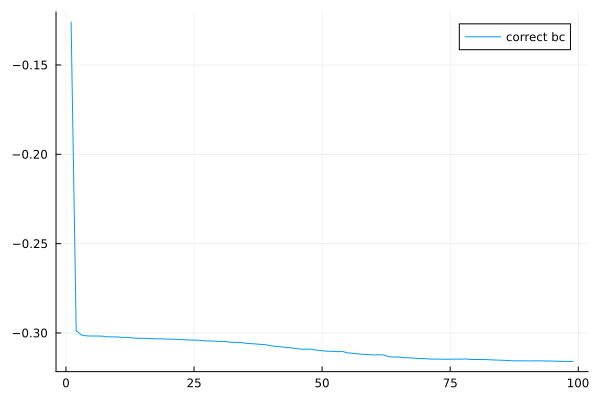

In [10]:
plot(log10.(loss_correct),label="correct bc")
#plot(log10.(loss_incorrect), label="incorrect bc")
#savefig("loss_advection_bc.png")

![loss for different boundary conditions](loss_advection_bc.png)

In [11]:

#ts, xs = [infimum(d.domain):dx:supremum(d.domain) for d in domains]
ts = collect(0.0:dx:tf)
xs = collect(0.0:dx:1.0)
function analytic_sol_func(t, x)
    #=
    v = (x+t)*(1 - (x+t))
    if v >= 0
        return v
    else
        return 0
    end
    =#
    if x + t <= 1
        return    sin(16*π*(x+t))
    else 
        return 0
    end
end


analytic_sol_func (generic function with 1 method)

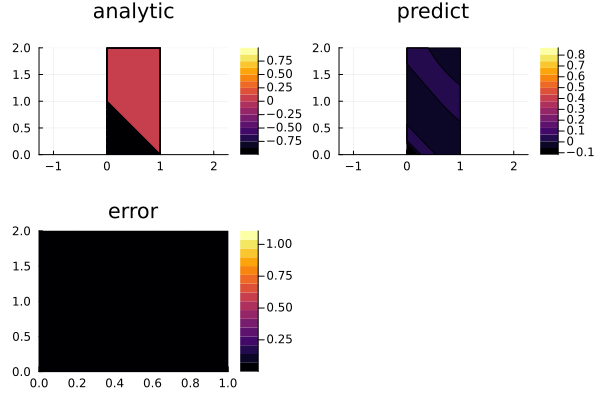

In [12]:

u_predict = reshape([first(phi([t, x], res.u)) for x in xs for t in ts],
    (length(ts), length(xs)))
u_real = reshape([analytic_sol_func(t, x) for x in xs for t in ts],
    (length(ts), length(xs)))

diff_u = abs.(u_predict .- u_real)

p1 = plot(xs, ts, u_real, linetype = :contourf, title = "analytic", aspectratio=1);
p2 = plot(xs, ts, u_predict, linetype = :contourf, title = "predict", aspectratio=1);
p3 = plot(xs, ts, diff_u, linetype = :contourf, title = "error");
plot(p1, p2, p3)


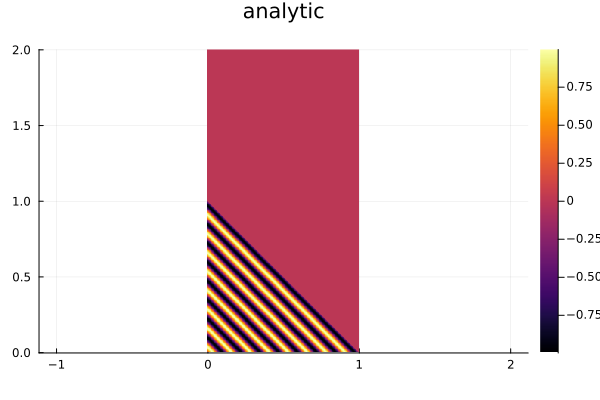

In [13]:
#plot(xs,u_real[50::])
heatmap(xs, ts, u_real, title = "analytic", aspectratio=1)

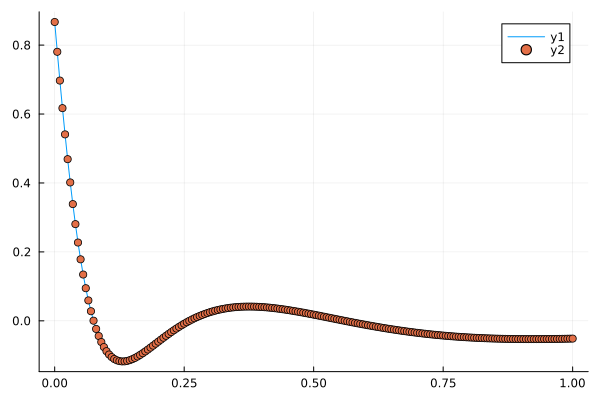

In [14]:
t = 0.0
sol_p = [first(phi([t, x], res.u)) for x in xs]
plot(xs,sol_p)
scatter!(xs,sol_p)

┌ Info: Time 0.0...
└ @ Main /Users/reula/Julia/PINN/Wave equations/Neural_PDE/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sZmlsZQ==.jl:2
┌ Info: Time 0.005...
└ @ Main /Users/reula/Julia/PINN/Wave equations/Neural_PDE/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sZmlsZQ==.jl:2
┌ Info: Time 0.01...
└ @ Main /Users/reula/Julia/PINN/Wave equations/Neural_PDE/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sZmlsZQ==.jl:2
┌ Info: Time 0.015...
└ @ Main /Users/reula/Julia/PINN/Wave equations/Neural_PDE/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sZmlsZQ==.jl:2
┌ Info: Time 0.02...
└ @ Main /Users/reula/Julia/PINN/Wave equations/Neural_PDE/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sZmlsZQ==.jl:2
┌ Info: Time 0.025...
└ @ Main /Users/reula/Julia/PINN/Wave equations/Neural_PDE/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sZmlsZQ==.jl:2
┌ Info: Time 0.03...
└ @ Main /Users/reula/Julia/PINN/Wave equations/Neural_PDE/jl_notebook_cell_df34fa98e6974

Plots.AnimatedGif("/Users/reula/Julia/PINN/Wave equations/Neural_PDE/advection.gif")
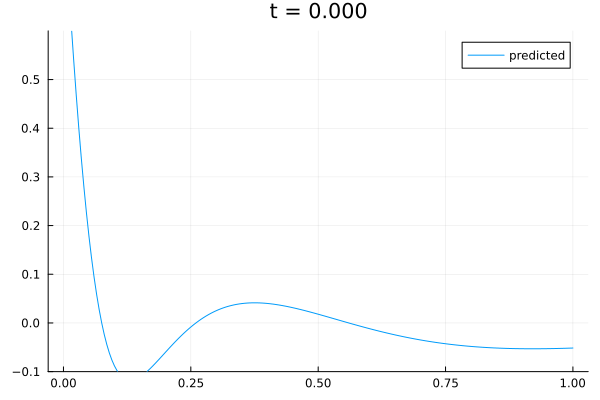

In [15]:
anim = @animate for t in ts
    @info "Time $t..."
    sol_p = [first(phi([t, x], res.u)) for x in xs]
    plot(ylims = [-0.1, 0.6])
    title = @sprintf("t = %.3f", t) 
    plot!(xs,sol_p, label="predicted", title=title)
end
gif(anim, "advection.gif", fps = 200)
